In [1]:
!pip install ipympl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 508 kB 5.2 MB/s 
     |████████████████████████████████| 11.2 MB 24.4 MB/s 
     |████████████████████████████████| 944 kB 36.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [3]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

from math import ceil, floor

import matplotlib.pyplot as plt # For general plotting
import matplotlib.colors as mcol
from matplotlib.ticker import MaxNLocator

import numpy as np

from scipy.stats import multivariate_normal as mvn
from sklearn.preprocessing import PolynomialFeatures # Important new include
from sklearn.model_selection import KFold # Important new include

from numpy.typing import NDArray
from scipy.optimize import minimize



from google.colab import output
output.enable_custom_widget_manager()
np.set_printoptions(suppress=True)

from mpl_toolkits.mplot3d import Axes3D 

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   #

In [11]:
# Forms a Vandermonde matrix with N values in x up to polynomial power d
def phi_transformation(X, d):
    # Repeat the array d number of times 
    X_d = np.tile(X, d)
    # Get evenly space values from 1 to d
    n_d = np.arange(d) + 1
    # Get the corresponding matrix of degrees to apply to each n-dimensional input in the dataset
    # First repeat each degree value per dimension for all x_i^d given a particular sample i
    # Then reshape the flattened vector into the original matrix shape, with -1 to adapt the number of columns
    degs = np.tile(np.repeat(n_d, X.shape[1]), X.shape[0]).reshape(X.shape[0], -1)
    # Compute polynomial powers given degrees matrix
    X_poly = np.power(X_d, degs)
    return X_poly


# Analytical optimal solution, aka the normal equation for least squares
# Fit order d polynomial usins training data set with MLE method which
# reduces to least-squares curve fitting here due to additive Gaussian noise
def mle_solution(X, y):
    # Model: y = phi(X)^T*theta
    # LS estimate: theta^* = (phi(X)^T*phi(X))^-1 * phi(X)^T * y 
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

def map_solution(X,y):
  
  gamma = np.logspace(-4, 4, X.shape[1])
  #I = np.identity(100)
  I = np.eye(X.shape[1])
  gamma_thresh = np.dot(gamma,I )
  #gamma_thresh = np.reshape(gamma_thresh, [100,2])
  return np.linalg.inv(gamma_thresh + X.T.dot(X)).dot(X.T).dot(y)


def mse(y_preds, y_true):
    # Residual error (X * theta) - y
    error = y_preds - y_true
    # Loss function is MSE
    return np.mean(error ** 2)

In [12]:
def hw2_q2(N, dataset_name):
    gmm_pdf = {}
    gmm_pdf['priors'] = np.array([.3, .4, .3])
    gmm_pdf['mu'] = np.array([[-10, 0, 10], [0, 0, 0], [10, 0, -10]])  # Gaussian distributions means
    gmm_pdf['Sigma'] = np.array([[[1, 0, -3], [0, 1, 0], [-3, 0, 15]], [[8, 0, 0], [0, .5, 0], [0, 0, .5]],
                                 [[1, 0, -3], [0, 1, 0], [-3, 0, 15]]])  # Gaussian distributions covariance matrices

    X, y = generate_gmm_data(N, gmm_pdf)

    # Plot the original data and their true labels
    fig = plt.figure(figsize=(10, 10))

    ax_raw = fig.add_subplot(111, projection='3d')

    ax_raw.scatter(X[:, 0], X[:, 1], y, marker='o', color='b')
    ax_raw.set_xlabel(r"$x_1$")
    ax_raw.set_ylabel(r"$x_2$")
    ax_raw.set_zlabel(r"$y$")
    # Set equal axes for 3D plots
    ax_raw.set_box_aspect((np.ptp(X[:, 0]), np.ptp(X[:, 1]), np.ptp(y)))

    plt.title("{} Dataset".format(dataset_name))
    plt.tight_layout()
    plt.show()

    return X, y


def generate_gmm_data(N, gmm_pdf):
    # Generates N vector samples from the specified mixture of Gaussians
    # Returns samples and their component labels
    # Data dimensionality is determined by the size of mu/Sigma parameters

    # Decide randomly which samples will come from each component
    u = np.random.random(N)
    thresholds = np.cumsum(gmm_pdf['priors'])
    thresholds = np.insert(thresholds, 0, 0)  # For intervals of classes

    n = gmm_pdf['mu'].shape[0]  # Data dimensionality

    X = np.zeros((N, n))
    C = len(gmm_pdf['priors'])  # Number of components
    for i in range(C + 1):
        # Get randomly sampled indices for this Gaussian, checking between thresholds based on class priors
        indices = np.argwhere((thresholds[i - 1] <= u) & (u <= thresholds[i]))[:, 0]
        # No. of samples in this Gaussian
        X[indices, :] = mvn.rvs(gmm_pdf['mu'][i - 1], gmm_pdf['Sigma'][i - 1], len(indices))

    return X[:, 0:2], X[:, 2]

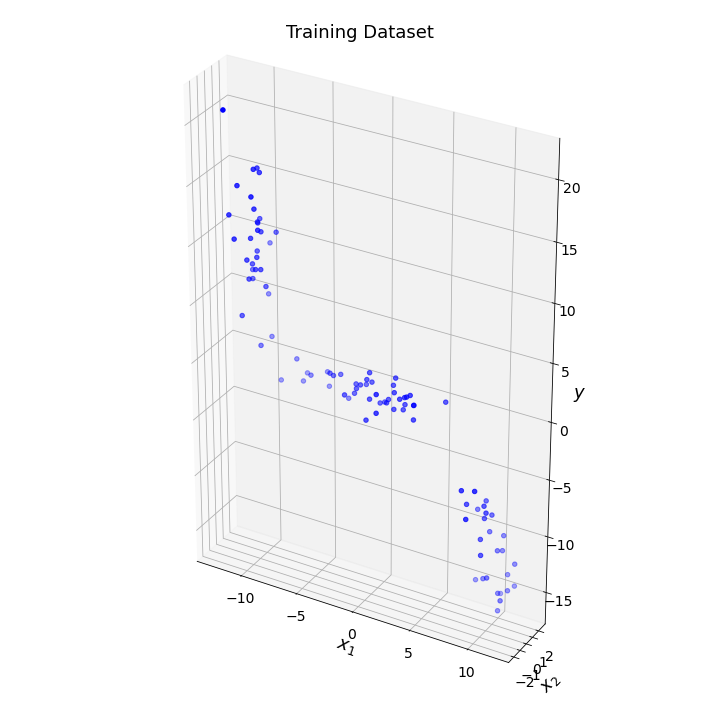

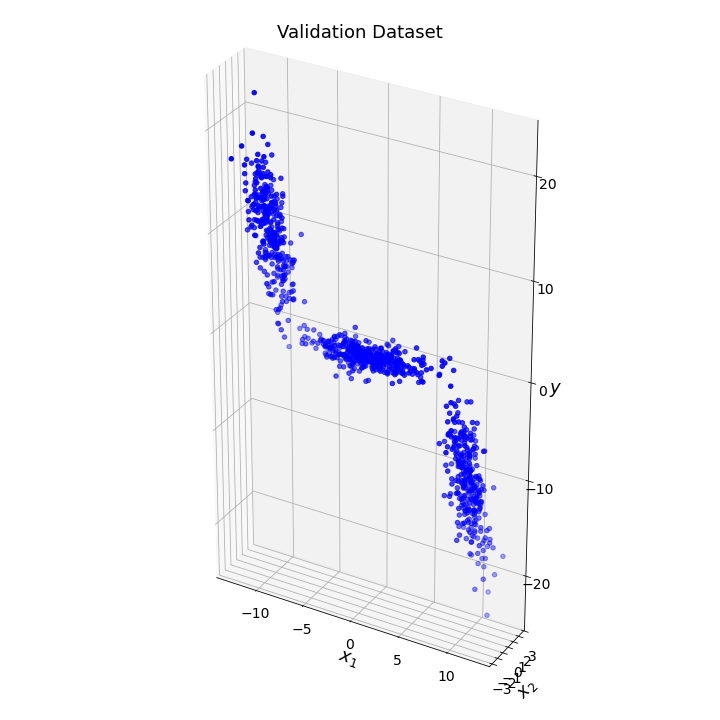

In [13]:
N_train = 100
N_valid = 1000

X_train, y_train = hw2_q2(N_train, "Training")
X_valid, y_valid = hw2_q2(N_valid, "Validation")

In [7]:
X_train.shape

(100, 2)

In [16]:
# Apply the phi transformation to create a Vandermonde matrix for order 3
X_train_poly = phi_transformation(X_train, d=3)
# Prepend column of ones
X_train_poly = np.column_stack((np.ones(N_train), X_train_poly))  
theta = mle_solution(X_train_poly, y_train)
theta_map = map_solution(X_train_poly,y_train)

# Create an ordered basis expansion of the training set for best line fit plotting
X0_train_bounds = np.linspace(min(X_train[:,0]), max(X_train[:,0]), N_train)
X1_train_bounds = np.linspace(min(X_train[:,1]), max(X_train[:,1]), N_train)
X_train_bounds = np.array((X0_train_bounds, X1_train_bounds)).T
X_train_bounds_poly = phi_transformation(X_train_bounds, d=3)
X_train_bounds_poly = np.column_stack((np.ones(N_train), X_train_bounds_poly))
y_train_predictions = X_train_bounds_poly.dot(theta)
y_train_predictions_map = X_train_bounds_poly.dot(theta_map)

# Only plot over the x1 feature-axis as that's visually sufficient
plt.ioff()
fig, ax = plt.subplots(figsize=(10, 10));
plt.ion()

ax.scatter(X_train[:, 0], y_train, marker='o', color='b', alpha=0.5);
ax.plot(X0_train_bounds, y_train_predictions, c='r', label="Best Fit Line");
ax.set_aspect('equal')


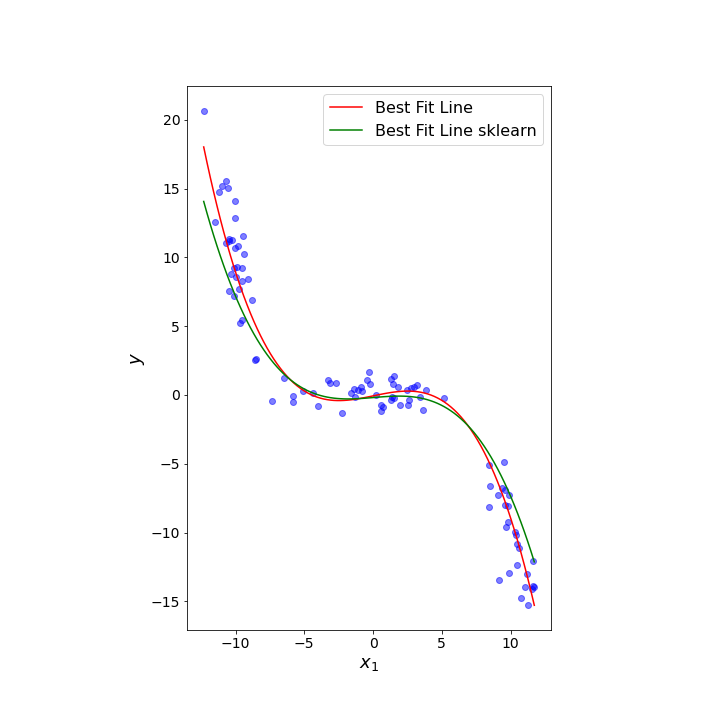

In [17]:
# The include_bias parameter will prepend the column of ones for us!
poly_features = PolynomialFeatures(degree=3, include_bias=True)
X_train_poly_sk = poly_features.fit_transform(X_train)

theta_sk = mle_solution(X_train_poly_sk, y_train)
theta_map_sk = map_solution(X_train_poly_sk, y_train)

# Use X bounds from before to transform the inputs 
X_train_bounds_poly_sk = poly_features.transform(X_train_bounds)
y_train_predictions_sk = X_train_bounds_poly_sk.dot(theta_sk)
y_train_predictions_map_sk = X_train_bounds_poly_sk.dot(theta_map_sk)

# Only plot over the X0-axis as that's visually sufficient
ax.plot(X0_train_bounds, y_train_predictions_sk, c='g', label="Best Fit Line sklearn")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$y$")
ax.legend()

plt.show()

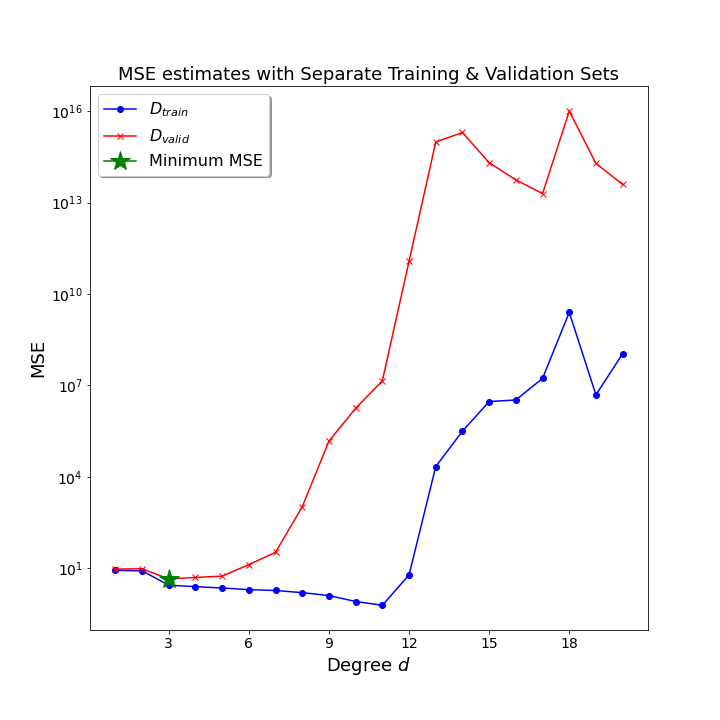

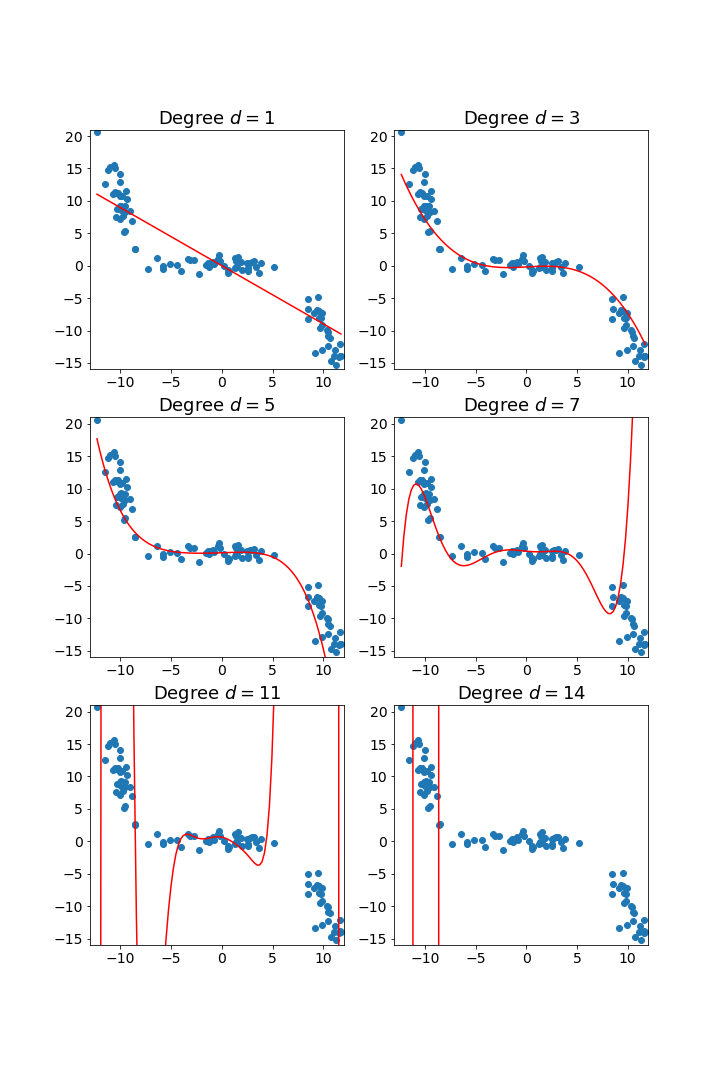

In [18]:
# Polynomial degrees ("hyperparameters") to evaluate 
degs = np.arange(1, 21, 1)
n_degs = np.max(degs)

# Allocate space for MSE train and validation error arrays
mse_train = np.empty(n_degs)
mse_valid = np.empty(n_degs)
mse_map_valid = np.empty(n_degs)
# Store predictions per degree using ordered X samples for plotting best fit lines
y_train_preds_ordered = np.empty(n_degs, dtype=np.ndarray)
for deg in degs:
    # Create polynomial features for the training data
    poly_features = PolynomialFeatures(degree=deg, interaction_only=False, include_bias=True)
    X_train_poly = poly_features.fit_transform(X_train)
    # Compute the normal equation/optimal solution for this degree deg data
    theta = mle_solution(X_train_poly, y_train)
    theta_map = map_solution(X_train_poly, y_train)
    #theta_map = map_solution(X_train_poly, y_train)
    # Make predictions on both the training and validation set
    y_train_pred = X_train_poly.dot(theta)
    y_train_map_pred = X_train_poly.dot(theta_map)

    # Use X bounds from before to transform the inputs for plots later
    X_train_bounds_poly = poly_features.transform(X_train_bounds)
    y_train_pred_ordered = X_train_bounds_poly.dot(theta)
    y_train_pred_map_ordered = X_train_bounds_poly.dot(theta_map)
    y_train_preds_ordered[deg - 1] = y_train_pred_ordered
    
    X_valid_poly = poly_features.transform(X_valid)
    y_valid_pred = X_valid_poly.dot(theta)
    y_valid_map_pred = X_valid_poly.dot(theta_map)
    
    # Record MSE as well
    mse_train[deg - 1] = mse(y_train_pred, y_train)
    mse_valid[deg - 1] = mse(y_valid_pred, y_valid)
    mse_map_valid[deg - 1] = mse(y_valid_map_pred, y_valid)


i = np.argmin(mse_valid)
x_min = degs[i]
y_min = mse_valid[i]

# Plot MSE vs degree
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(degs, mse_train, color="b", marker="o", label=r"$D_{train}$")
ax.plot(degs, mse_valid, color="r", marker="x", label=r"$D_{valid}$")
ax.plot(x_min, y_min,color="g", marker="*", markersize = 20, label=r"Minimum MSE" )

# Use logarithmic y-scale as MSE values get very large
ax.set_yscale('log')
# Force x-axis for degrees to be integer
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.legend(loc='upper left', shadow=True)
plt.xlabel(r"Degree $d$")
plt.ylabel("MSE")
plt.title("MSE estimates with Separate Training & Validation Sets")
plt.show()

fig_reg = plt.figure(figsize=(10, 15))
X0_train_lim = (floor(np.min(X0_train_bounds)), ceil(np.max(X0_train_bounds)))
X1_train_lim = (floor(np.min(X1_train_bounds)), ceil(np.max(X1_train_bounds)))
y_train_lim = (floor(np.min(y_train)), ceil(np.max(y_train)))

chosen_degs = [1, 3, 5, 7, 11, 14]
i = 1
# Plot fit vs actual
for deg in chosen_degs:
    ax_reg = fig_reg.add_subplot(3, 2, i)#, projection='3d')
    ax_reg.scatter(X_train[:, 0], y_train)
    ax_reg.plot(X0_train_bounds, y_train_preds_ordered[deg - 1], 'r')
    ax_reg.set_xlim(X0_train_lim)
    ax_reg.set_ylim(y_train_lim)
    ax_reg.set_title(r"Degree $d={%d}$" % deg)
    i += 1

plt.show()

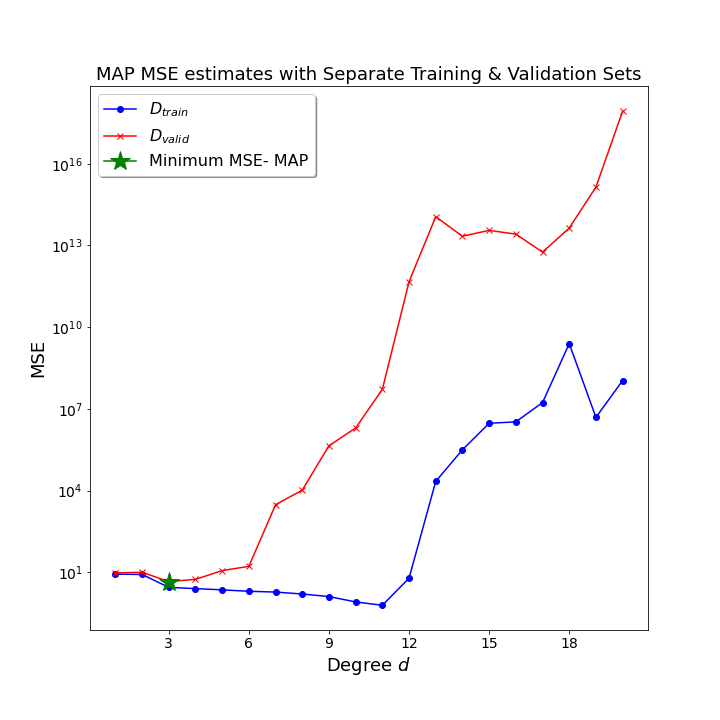

In [20]:
# Plot MSE vs degree
i_map = np.argmin(mse_map_valid)
x_min_map = degs[i_map]
y_min_map = mse_valid[i_map]
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(degs, mse_train, color="b", marker="o", label=r"$D_{train}$")
ax.plot(degs, mse_map_valid, color="r", marker="x", label=r"$D_{valid}$")
ax.plot(x_min_map, y_min_map,color="g", marker="*", markersize = 20, label=r"Minimum MSE- MAP" )

# Use logarithmic y-scale as MSE values get very large
ax.set_yscale('log')
# Force x-axis for degrees to be integer
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.legend(loc='upper left', shadow=True)
plt.xlabel(r"Degree $d$")
plt.ylabel("MSE")
plt.title("MAP MSE estimates with Separate Training & Validation Sets")
plt.show()

In [21]:

print('Minimum MSE associated with MAP', y_min_map)

Minimum MSE associated with MAP 4.553235011768968


In [ ]:
print('Minimum MSE associated with MLE', y_min)

Minimum MSE associated with MLE 5.583247585813211
